# Divergencia Kullback-Leibler
https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained

Es una medida no simétrica de la similitud o diferencia entre dos funciones de distribución de probabilidad P y Q.

$$ D_{KL}(p \parallel q) = \sum_i P(x_i)\ln{\frac{P(x_i)}{Q(x_i)}} $$

Podemos reescribir la expresión anterior de esta manera:

$$ D_{KL}(P \parallel Q) = \sum_i P(x_i) [\ln{P(x_i)} - \ln{Q(x_i)}] $$

Y también de esta otra:

$$ D_{KL}(P \parallel Q) = \sum_i P(x_i) \cdot \ln{P(x_i)} - \sum_i P(x_i) \cdot \ln{Q(x_i)} $$

A $\sum_i P(x_i) \cdot \ln{Q(x_i)}$ la llamaremos **entropía cruzada** $H(P,Q)$, y corresponde al cálculo del número de bits promedio necesarios para codificar un mensaje cuando el sistema de codificación está basado en una distribución de probabilidad que no corresponde a la distribución real.

Recordando lo que vimos sobre la entropía (apartado 2 del ejercicio), $H(P,Q)$ nos devolverá siempre un valor mayor que la entropía $H(X)$.

Por tanto, la divergencia *Kullback-Leibler* nos indica la diferencia (divergencia) entre dos distribuciones de probabilidad basada en la diferencia entre la entropía de la primera de las distribuciones de probabilidad y la entropía cruzada entre la primera y la segunda.

$$ D_{KL}(P \parallel Q) = -H(P) + H(P,Q)  $$

Sus propiedades más destacadas son:
 - Su valor siempre será positivo
 - Solamente será nula cuando ambas distribuciones sean idénticas, $P = Q $
 - No es simétrica
 - No es una distancia

## Medida de la divergencia entre dos distribuciones de probabilidad

KL(P||Q) = 1.443


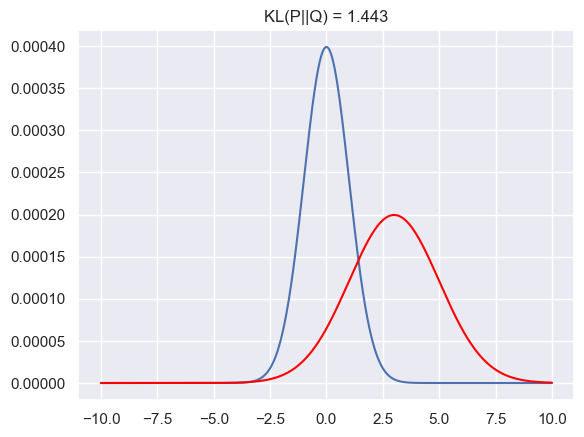

In [55]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
# import tensorflow as tf
import seaborn as sns
sns.set()

def kl_divergence(p, q):
    return np.sum(np.where(q != 0, p * np.log(p / q), 0))

x = np.arange(-10, 10, 0.001)
p = norm.pdf(x, 0, 1)
p = p/np.sum(p)
q = norm.pdf(x, 3, 2)
q = q/np.sum(q)

plt.title('KL(P||Q) = %1.3f' % kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red')

print('KL(P||Q) = %1.3f' % kl_divergence(p, q))

## Minimizando la divergencia KL

Podemos utilizar la divergencia KL como función de pérdida para tratar de convertir una distribución en otra. En el siguiente código veremos cómo llevar la media y la desviación de unas distribución normal hacia los valores de otra distribución normal mediante la minimización del valor de KL.

$\mathcal{N}(\mu,\,\sigma^{2})$

In [60]:
import torch

start_mu = 0.
start_sigma = 1.

target_mu = 3.
target_sigma = 2.

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_np = np.arange(-25, 25, 0.1)
x = torch.from_numpy(x_np).float().to(device)

mu = torch.tensor(start_mu, requires_grad=True, dtype=torch.float, device=device)
sigma = torch.tensor(start_sigma, requires_grad=True, dtype=torch.float, device=device)

optimizer = torch.optim.SGD([mu, sigma], lr=0.1)

def normal(x, _mu, _sigma):
    return 1./(_sigma * 2.506628) * torch.exp( (-(x - _mu)**2.) / (2. * _sigma**2.))  # sqrt(2 * pi) = 2.506628

def KL(p, q):
    # return torch.where(q > 1e-8, p * torch.log(p / q), torch.tensor([0.], device=device)).sum()        
    aux = torch.tensor(0., dtype=torch.float, device=device)    
    for pv, qv in zip(p, q):                
        if qv > 1e-8:  # if qv != 0:                
            aux += pv * torch.log(pv / qv)    
    return aux
    
tensor_target_mu = torch.tensor(target_mu, dtype=torch.float, device=device)
tensor_target_sigma = torch.tensor(target_sigma, dtype=torch.float, device=device)

P = normal(x, tensor_target_mu, tensor_target_sigma)
P = P / P.sum()

for i in range(200):
    Q = normal(x, mu, sigma)
    Q = Q / Q.sum()
    loss = KL(P, Q)   
    loss.backward()
    optimizer.step()    
    optimizer.zero_grad()
    
    if i%10 == 0:
        print("Iteración:", i, "mu:", mu.data.cpu().numpy(), "sigma:", sigma.data.cpu().numpy(), "KL:", loss.data.cpu().numpy())

Iteración: 0 mu: 0.23427384 sigma: 1.7759844 KL: 3.3698084
Iteración: 10 mu: 0.7874559 sigma: 2.3993926 KL: 0.47652113
Iteración: 20 mu: 1.1232235 sigma: 2.5396068 KL: 0.33129933
Iteración: 30 mu: 1.3908292 sigma: 2.571197 KL: 0.25565386
Iteración: 40 mu: 1.619231 sigma: 2.5523589 KL: 0.20190376
Iteración: 50 mu: 1.8199474 sigma: 2.5059178 KL: 0.15877342
Iteración: 60 mu: 1.9985174 sigma: 2.4443116 KL: 0.122592844
Iteración: 70 mu: 2.1577494 sigma: 2.3758352 KL: 0.0921133
Iteración: 80 mu: 2.299046 sigma: 2.306683 KL: 0.06694976
Iteración: 90 mu: 2.423125 sigma: 2.2415953 KL: 0.04691633
Iteración: 100 mu: 2.5305092 sigma: 2.1839316 KL: 0.031691037
Iteración: 110 mu: 2.6218717 sigma: 2.1355996 KL: 0.02069289
Iteración: 120 mu: 2.698232 sigma: 2.0970995 KL: 0.01313171
Iteración: 130 mu: 2.760986 sigma: 2.0677931 KL: 0.00815398
Iteración: 140 mu: 2.8118067 sigma: 2.04634 KL: 0.0049876343
Iteración: 150 mu: 2.8524733 sigma: 2.0311341 KL: 0.0030225187
Iteración: 160 mu: 2.8847172 sigma: 2.0

Si trazamos las dos distribuciones veremos que están superpuestas, son las mismas.

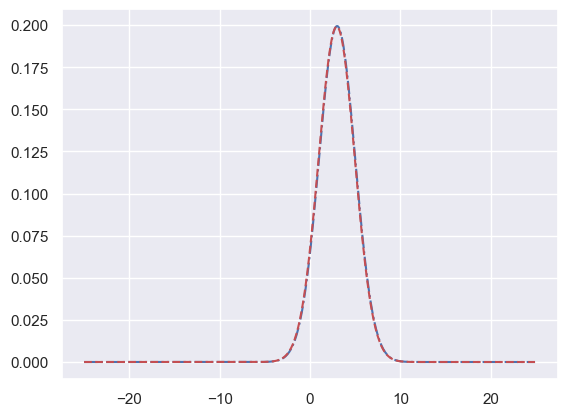

In [61]:
p = norm.pdf(x_np, target_mu, target_sigma)
q = norm.pdf(x_np, mu.data.cpu().numpy(), sigma.data.cpu().numpy())

plt.plot(x_np, p, 'b-.')
plt.plot(x_np, q, 'r--')



## Ejercicios

Tenemos las distribuciones $d1$ y $d2$ con las representaciones siguientes. Ambas distribuciones son diferentes. Nuestro objetivo es convertir la distribución $d2$ en la distribución $d1$. Para ello convertiremos primero las distribuciones en distribuciones de probabilidad. Luego desarrollaremos un *script* con PyTorch donde compararemos las dos distribuciones mediante la divergencia de Kullback-Leibler y, mediante descenso por el gradiente, iremos igualando las distribuciones.

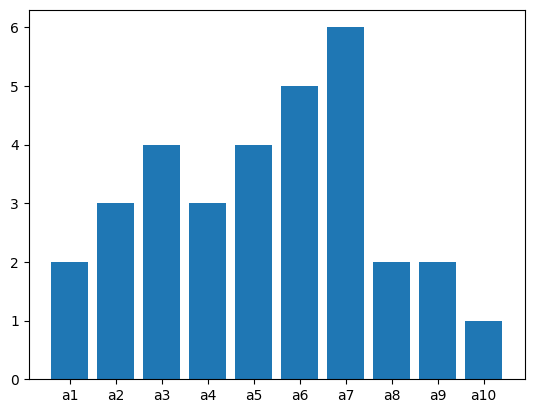

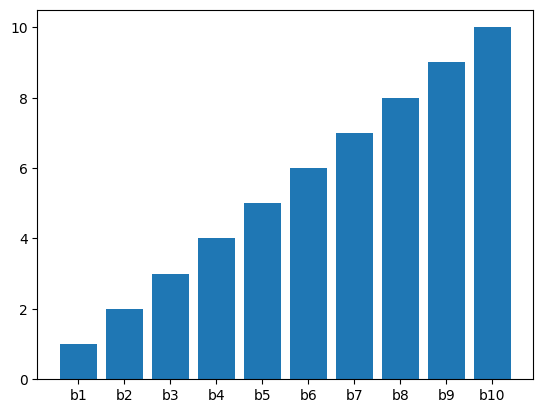

In [14]:
import numpy as np
import matplotlib.pyplot as plt

d1_names = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10']
d1 = [2,3,4,3,4,5,6,2,2,1]

d2_names = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10']
d2 = [1,2,3,4,5,6,7,8,9,10]

plt.bar(d1_names, d1)
plt.show()

plt.bar(d2_names, d2)
plt.show()
